In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
# # /kaggle/input/brain-tumor-mri-dataset/Training/

In [2]:
import torch
import torchvision
from torch import nn
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import time
import torch
import numpy 
from torch import nn
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import random_split
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import random
import zipfile
from pathlib import Path
import requests


In [3]:

def computeAccu(model,dataLoader,device):
  model.eval()
  with torch.no_grad():
    correctPred = 0
    totalPred = 0

    for features,targets in dataLoader:
      features = features.to(device)
      targets  = targets.to(device)

      logits   = model(features)
      _ , predLabel = torch.max(logits,1)
      totalPred += targets.size(0)
      correctPred += (predLabel == targets).sum()

  return correctPred.float()/totalPred * 100
def setAllSeeds(seed):
  os.environ['MY_GLOBAL_SEED'] = str(seed)
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

In [4]:

def getEffNetModel(seed,numClasses):
  setAllSeeds(seed)
  effNetWeights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  effNetTransforms = effNetWeights.transforms()
  effNet = torchvision.models.efficientnet_b2(weights=effNetWeights)
  for param in effNet.parameters():
    param.requires_grad = False
  effNet.classifier = nn.Sequential(
    nn.Dropout(p=0.3,inplace=True),
    nn.Linear(1408,numClasses,bias=True)
  )
  return effNet,effNetTransforms


In [5]:
model, transformers = getEffNetModel(42,4)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 61.5MB/s]


In [6]:
trainDir = '/kaggle/input/brain-tumor-mri-dataset/Training/'
testDir  = '/kaggle/input/brain-tumor-mri-dataset/Testing/'
# valDir   = '/kaggle/input/chest-ctscan-images/Data/valid/'
batchSize = 32
randomSeed = 42
numEpochs = 25
seed = 42
splitSize = 0.9
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
trainData = datasets.ImageFolder(trainDir, transform=transformers)
num = int(len(trainData) * splitSize)
trainDataset, valDataset  = random_split(trainData, lengths=[num, len(trainData)-num], generator=torch.manual_seed(seed))
testDataset = datasets.ImageFolder(testDir, transform=transformers)
classNames = trainData.classes
trainDataloader = DataLoader(
  trainDataset,
  batch_size=batchSize,
  shuffle=True,
  num_workers=0,
  pin_memory=True,
)
classNames = trainData.classes
testDataloader = DataLoader(
  testDataset,
  batch_size=batchSize,
  shuffle=False, # don't need to shuffle test data
  num_workers=0,
  pin_memory=True,
)
# valData = datasets.ImageFolder(valDir, transform=transformers)
valDataloader = DataLoader(
  valDataset,
  batch_size=batchSize,
  shuffle=False, # don't need to shuffle test data
  num_workers=0,
  pin_memory=True,
)

In [8]:
for images, labels in trainDataloader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([32, 3, 288, 288])
Image label dimensions: torch.Size([32])
Class labels of 10 examples: tensor([1, 0, 3, 1, 2, 3, 0, 2, 1, 1])


In [9]:
def modelTrainer(model1, numEpochs, trainLoader,testLoader,valLoader, opt, device,scheduler=None,schedulerOn='validAcc'):
  startTime = time.time()
  miniBatchLoss = []
  trainAccLoss = []
  valAccLoss = []
  valPlotAccLoss =[]
  for e in range(numEpochs):
    model1.train()
    for batchIdx, (features,targets) in enumerate(trainLoader):
      features = features.to(device)
      targets  = targets.to(device)

      logits = model1(features)
      # _, predLabel = torch.max(logits,1)

      cost = torch.nn.functional.cross_entropy(logits,targets)
      opt.zero_grad()
      cost.backward()
      opt.step()
      miniBatchLoss.append(cost.item())
      if ( not (batchIdx%25) ):
        print('Epoch:%03d/%03d | Batch:%03d/%03d |  Cost:%.4f' %(e+1, numEpochs, batchIdx, len(trainLoader), cost.item()))
    with torch.no_grad():
      print('Epoch:%03d/%03d |' %(e+1, numEpochs))
      trainLoss = computeAccu(model1, trainLoader,device)
      valLoss   = computeAccu(model1, valLoader  ,device)
      valAccLoss.append(valLoss)
      trainAccLoss.append(trainLoss.cpu().numpy())
      
      print(f'Train Acc {trainLoss :.4f}%')
      print(f'Val Acc   {valLoss:.4f}%')
      print(f'Time Taken: {((time.time()-startTime)/60):.2f} min')
      if(scheduler is not None):
        if(schedulerOn == 'validAcc'):
          scheduler.step(valAccLoss[-1])
        elif(schedulerOn == 'miniBatchLoss'):
          scheduler.step(miniBatchLoss[-1])
        else:
          raise ValueError(f'invalid choice for SchedulerOn {schedulerOn}')
      # valAccLoss[-1] = valLoss.detach().numpy()
      valPlotAccLoss.append(valLoss.cpu().numpy())
#     break
    if(((e+1)%7)):
        torch.save(model1.state_dict(), f'model{e+1}.pt')
        torch.save(opt.state_dict(), f'optimizer{e+1}.pt')
        torch.save(scheduler.state_dict(), f'schd{e+1}.pt')
  testLoss = computeAccu(model1, testLoader, device)
  print(f'Test Acc   {testLoss:.4f}%')
  print(f'Total Time Taken: {((time.time()-startTime)/60):.2f} min')

  return miniBatchLoss, trainAccLoss, valPlotAccLoss 


In [10]:
model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9,lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

In [11]:
setAllSeeds(42)
miniBatchLossList, trainAccList, validAccList = modelTrainer(
    model1=model,
    numEpochs=numEpochs,
    trainLoader=trainDataloader,
    valLoader=valDataloader,
    testLoader=testDataloader,
    opt=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    schedulerOn='validAcc')

Epoch:001/025 | Batch:000/161 |  Cost:1.3598
Epoch:001/025 | Batch:025/161 |  Cost:0.5323
Epoch:001/025 | Batch:050/161 |  Cost:0.5567
Epoch:001/025 | Batch:075/161 |  Cost:0.7560
Epoch:001/025 | Batch:100/161 |  Cost:0.3307
Epoch:001/025 | Batch:125/161 |  Cost:1.1815
Epoch:001/025 | Batch:150/161 |  Cost:0.6813
Epoch:001/025 |
Train Acc 89.7276%
Val Acc   88.9860%
Time Taken: 1.80 min
Epoch:002/025 | Batch:000/161 |  Cost:0.9503
Epoch:002/025 | Batch:025/161 |  Cost:0.5239
Epoch:002/025 | Batch:050/161 |  Cost:0.7841
Epoch:002/025 | Batch:075/161 |  Cost:1.0430
Epoch:002/025 | Batch:100/161 |  Cost:1.1868
Epoch:002/025 | Batch:125/161 |  Cost:0.4020
Epoch:002/025 | Batch:150/161 |  Cost:0.5159
Epoch:002/025 |
Train Acc 92.3541%
Val Acc   91.4336%
Time Taken: 3.26 min
Epoch:003/025 | Batch:000/161 |  Cost:0.6552
Epoch:003/025 | Batch:025/161 |  Cost:0.7431
Epoch:003/025 | Batch:050/161 |  Cost:1.7037
Epoch:003/025 | Batch:075/161 |  Cost:0.9913
Epoch:003/025 | Batch:100/161 |  Cost:0.

In [12]:

def plotTrainingLoss(miniBatchLoss,numEpoch,iterPerEpoch,resultsDir=None,avgIter = 100):
  plt.figure()
  ax1 = plt.subplot(1,1,1)
  ax1.plot(range(len(miniBatchLoss)), miniBatchLoss, label='Mini Batch Loss')
  if len(miniBatchLoss) > 1000:
    ax1.set_ylim([0,np.max(miniBatchLoss[1000:])*1.5])
  ax1.set_xlabel('Iterations')
  ax1.set_ylabel('Loss')
  ax1.plot(np.convolve(miniBatchLoss,np.ones(avgIter,)/avgIter,mode='valid'),label='Running Avg')
  ax1.legend()

  ax2 = ax1.twiny()
  newLabel = list(range(numEpoch+1))
  newPos = [e*iterPerEpoch for e in newLabel]
  # ax2.set_xticks(newpos[::10])
  # ax2.set_xticklabels(newlabel[::10])

  ax2.set_xticks(newPos[::10])
  ax2.set_xticklabels(newLabel[::10])
  ax2.spines['bottom'].set_position(('outward',45))
  ax2.set_xlabel("Epochs")
  ax2.set_xlim(ax1.get_xlim())

  plt.tight_layout()

  if(resultsDir is not None):
    imagePath = os.path.join(resultsDir, 'plotTrainingLoss.pdf')
    plt.savefig(imagePath)

def plotAccuracy(trainAccList, valAccList, resultsDir = None):
  numEpoch = len(trainAccList)
  plt.plot(np.arange(1,numEpoch+1),trainAccList,label='Training')
  plt.plot(np.arange(1,numEpoch+1),valAccList,label='Validation')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout()


  if(resultsDir is not None):
    imagePath = os.path.join(resultsDir, 'plotAccTrainingValidation.pdf')
    plt.savefig(imagePath)

def show_examples(model, dataLoader):
  for batchIdx, (features, targets) in enumerate(dataLoader):
    with torch.no_grad():
      features = features.to(torch.device('cpu'))
      targets  = targets.to(torch.device('cpu'))
      logits = model(features)
      predictions = torch.argmax(logits,dim=1)
    break

  fig, axes = plt.subplots(nrows=3,ncols=5,sharex=True,sharey=True)
  nhwcImage = np.transpose(features,axes = (0,2,3,1))
  nhwImage  = np.squeeze(nhwcImage.numpy(), axis=3)

  for idx,ax in enumerate(axes.ravel()):
    ax.imshow(nhwImage[idx],cmap='binary')
    ax.title.set_text(f'P: {predictions[idx]} | T: {targets[idx]}')
    ax.axison = False

  plt.tight_layout()
  plt.show()


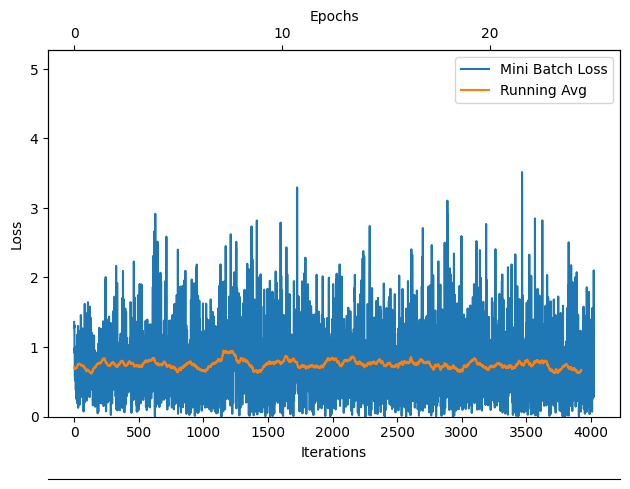

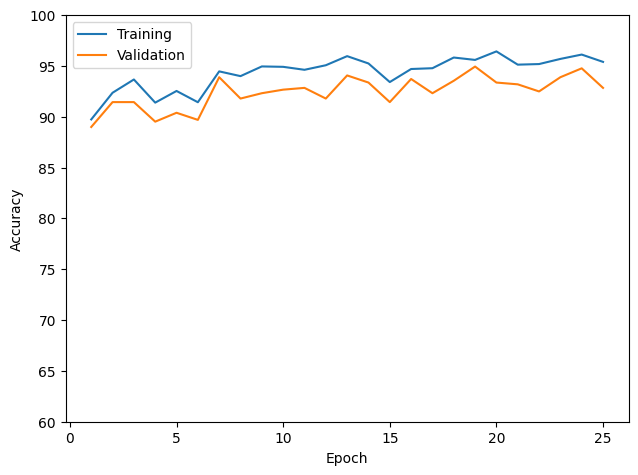

In [13]:
plotTrainingLoss(miniBatchLoss=miniBatchLossList,
                   numEpoch=numEpochs,
                   iterPerEpoch=len(trainDataloader),
                   resultsDir=None,
                   avgIter=100)    #plotTrainingLoss(miniBatchLoss,numEpoch,iterPerEpoch,resultsDir=None,avgIter = 100)
plt.show()
plotAccuracy(trainAccList,validAccList)
plt.ylim([60,100])
plt.show()

In [14]:
torch.save(model.state_dict(), 'model.pt')
torch.save(optimizer.state_dict(), 'optimizer.pt')
torch.save(scheduler.state_dict(), 'scheduler.pt')